# Predecir Spam con una RNN

In [3]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

In [1]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

In [20]:
data_dir = "../../datasets/sms_spam"
data_file = "text_data.txt"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
if not os.path.isfile(os.path.join(data_dir, data_file)):
    #hay que descargar fichero
    r = requests.get(url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read("SMSSpamCollection")
    text_data = file.decode()
    text_data = text_data.encode("ascii", errors="ignore")
    text_data = text_data.decode().split("\n")
    with open(os.path.join(data_dir, data_file), "w") as file_content:
        for text_line in text_data:
            file_content.write("{}\n".format(text_line))
else:
    #hay que cargar fichero
    text_data = []
    with open(os.path.join(data_dir, data_file), "r") as file_content:
        for text_line in file_content:
            text_data.append(text_line)

In [21]:
text_data = [x.split("\t") for x in text_data if len(x)>1]

In [33]:
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [32]:
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+','', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string

In [29]:
text_data_train[:5]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n',
 'Ok lar... Joking wif u oni...\n',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n",
 'U dun say so early hor... U c already then say...\n',
 "Nah I don't think he goes to usf, he lives around here though\n"]

In [34]:
text_data_train = [clean_text(x) for x in text_data_train]

In [36]:
text_data_train[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

In [38]:
session = tf.Session()
epochs = 20
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

In [39]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length, 
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [41]:
text_processed[0]

array([ 44, 455,   0, 809, 703, 667,  62,   9,   0,  87, 120, 366,   0,
       152,   0,   0,  66,  56,   0, 136,   0,   0,   0,   0,   0])

In [42]:
text_data_train[0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

In [43]:
text_data_target = np.array([1 if x == "ham" else 0 for x in text_data_target])

In [44]:
shuffle_ix = np.random.permutation(np.arange(len(text_data_target)))

In [45]:
x_shuffled = text_processed[shuffle_ix]
y_shuffled = text_data_target[shuffle_ix]

In [46]:
ix_cuttoff = int(len(x_shuffled)*0.8)
x_train, x_test = x_shuffled[:ix_cuttoff], x_shuffled[ix_cuttoff:]
y_train, y_test = y_shuffled[:ix_cuttoff], y_shuffled[ix_cuttoff:]

In [47]:
vocab_size = len(vocab_processor.vocabulary_)
vocab_size

933

In [48]:
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [49]:
embedding_matrix = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_matrix, x_data)

In [50]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype = tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [53]:
output = tf.transpose(output, [1,0,2])
last = tf.gather(output, int(output.get_shape()[0])-1)

In [54]:
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.add(tf.matmul(last, weight), bias))

In [55]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output))

In [56]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out,1), tf.cast(y_output, tf.int64)), tf.float32))

In [57]:
optim = tf.train.RMSPropOptimizer(learning_rate)
train_step = optim.minimize(loss)
session.run(tf.global_variables_initializer())

/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [58]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(epochs):
    shuffle_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffle_ix]
    y_train = y_train[shuffle_ix]
    
    num_batches = int(len(x_train)/batch_size)+1
    
    for i in range(num_batches):
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1)*batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        session.run(train_step, feed_dict=train_dict)
    
    temp_train_loss, temp_train_acc = session.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_acc.append(temp_train_acc)
    
    test_dict = {x_data: x_test, y_output:y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = session.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_acc.append(temp_test_acc)
    print("Epoch {} completado, Loss: {:.3f}, Acc: {:.3f}".format(i+1, temp_test_loss, temp_test_acc))

Epoch 18 completado, Loss: 0.722, Acc: 0.166
Epoch 18 completado, Loss: 0.711, Acc: 0.167
Epoch 18 completado, Loss: 0.693, Acc: 0.179
Epoch 18 completado, Loss: 0.666, Acc: 0.847
Epoch 18 completado, Loss: 0.631, Acc: 0.849
Epoch 18 completado, Loss: 0.595, Acc: 0.848
Epoch 18 completado, Loss: 0.564, Acc: 0.849
Epoch 18 completado, Loss: 0.535, Acc: 0.851
Epoch 18 completado, Loss: 0.513, Acc: 0.854
Epoch 18 completado, Loss: 0.498, Acc: 0.864
Epoch 18 completado, Loss: 0.487, Acc: 0.863
Epoch 18 completado, Loss: 0.478, Acc: 0.868
Epoch 18 completado, Loss: 0.471, Acc: 0.871
Epoch 18 completado, Loss: 0.465, Acc: 0.874
Epoch 18 completado, Loss: 0.460, Acc: 0.877
Epoch 18 completado, Loss: 0.455, Acc: 0.879
Epoch 18 completado, Loss: 0.451, Acc: 0.880
Epoch 18 completado, Loss: 0.448, Acc: 0.882
Epoch 18 completado, Loss: 0.445, Acc: 0.879
Epoch 18 completado, Loss: 0.443, Acc: 0.879


In [59]:
epoch_seq = np.arange(1, epochs+1)

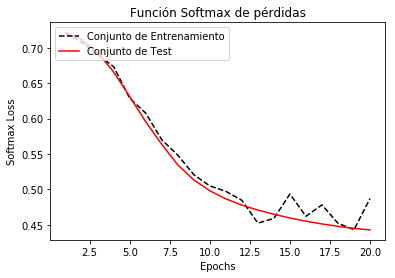

In [60]:
plt.plot(epoch_seq, train_loss, 'k--', label="Conjunto de Entrenamiento")
plt.plot(epoch_seq, test_loss, 'r-', label = "Conjunto de Test")
plt.title("Función Softmax de pérdidas")
plt.xlabel("Epochs")
plt.ylabel("Softmax Loss")
plt.legend(loc="upper left")
plt.show()

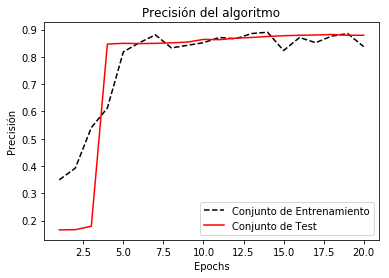

In [62]:
plt.plot(epoch_seq, train_acc, 'k--', label="Conjunto de Entrenamiento")
plt.plot(epoch_seq, test_acc, 'r-', label = "Conjunto de Test")
plt.title("Precisión del algoritmo")
plt.xlabel("Epochs")
plt.ylabel("Precisión")
plt.legend(loc="lower right")
plt.show()